[![nbviewer](https://img.shields.io/badge/render-nbviewer-orange.svg)](https://nbviewer.org/github/maciejskorski/sqlfluff-lineage/blob/main/sqlfluff_lineage.ipynb)


# Summary

The notebook shows how to use the sqlfluff parser to obtain the table lineage on complex ClickHouse queries.

The main idea is to use [sqlfluff](https://github.com/sqlfluff/sqlfluff) as the parser, and then extract the Abstract Syntax Tree into the convenient [anytree format](https://github.com/c0fec0de/anytree).


# Preliminaries

In [1]:
!pip install git+https://github.com/sqlfluff/sqlfluff.git --quiet
!pip install anytree --quiet

  Cloning https://github.com/sqlfluff/sqlfluff.git to /tmp/pip-req-build-__868u34
  Running command git clone --filter=blob:none --quiet https://github.com/sqlfluff/sqlfluff.git /tmp/pip-req-build-__868u34
  Resolved https://github.com/sqlfluff/sqlfluff.git to commit f7557854dedcde389b10903601d55f77197fe3e9
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.9/51.9 kB 3.5 MB/s eta 0:00:00
  Created wheel for sqlfluff: filename=sqlfluff-3.1.0-py3-none-any.whl size=795893 sha256=d636b2f1e0fa9d20c1254ae2f95e73df4bcfb4b4c01a5cdd2d5d1637e44ac947
  Stored in directory: /tmp/pip-ephem-wheel-cache-ujzde3ur/wheels/95/2d/d8/ec7d6fd4c47bf8b3257e7cb3c22d23c9725c827749de97cef3
Successfully built sqlfluff
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.9/44.9 kB 3.3 MB/s eta 0:00:00


# Parsing

In [4]:
import sqlparse
import sqlfluff

with open("query.txt","r") as f:
    sql_text = f.read()

statements = sqlparse.split(sql_text)

statements_parsed = []

for stmnt in statements:
    stmnt_format = sqlparse.format(stmnt, reindent=True, keyword_case='upper')
    if 'SET ' in stmnt_format:
      continue
    stmnt_parsed = sqlfluff.parse(stmnt, dialect='clickhouse')
    statements_parsed.append(stmnt_parsed)

# Building AST

In [6]:
import anytree
from anytree import Node, AnyNode, RenderTree, AsciiStyle

def get_tree(data, root=None):
  if not root:
    root = AnyNode(id='root')
  if isinstance(data, list):
    for v in data:
      get_tree(v, root)
  if isinstance(data, dict):
    for k,v in data.items():
      nv = anytree.AnyNode(token=k, parent=root)
      if not isinstance(v, dict) and not isinstance(v, list):
        nv.value = v
      get_tree(v, nv)
  return root

def get_ref_tables(root):
  tables = []
  nodes = anytree.search.findall(root, lambda node: getattr(node,"token","") == 'table_reference')
  for n in nodes:
    t = ''.join( getattr(c,'value','') for c in n.children)
    tables.append(t)
  return tables


stmnt = statements_parsed[0]
data = stmnt['file']
root = get_tree(data)
print(RenderTree(root, style=AsciiStyle()))

AnyNode(id='root')
|-- AnyNode(token='statement')
|   +-- AnyNode(token='create_table_statement')
|       |-- AnyNode(token='keyword', value='CREATE')
|       |-- AnyNode(token='whitespace', value=' ')
|       |-- AnyNode(token='keyword', value='TABLE')
|       |-- AnyNode(token='whitespace', value=' ')
|       |-- AnyNode(token='table_reference')
|       |   |-- AnyNode(token='naked_identifier', value='murmuras')
|       |   |-- AnyNode(token='dot', value='.')
|       |   +-- AnyNode(token='naked_identifier', value='app_log_trivial_tmp')
|       |-- AnyNode(token='newline', value='\n')
|       |-- AnyNode(token='engine')
|       |   |-- AnyNode(token='keyword', value='ENGINE')
|       |   |-- AnyNode(token='whitespace', value=' ')
|       |   |-- AnyNode(token='comparison_operator')
|       |   |   +-- AnyNode(token='raw_comparison_operator', value='=')
|       |   |-- AnyNode(token='whitespace', value=' ')
|       |   |-- AnyNode(token='table_engine_function')
|       |   |   +-- Any

In [7]:
import networkx as nx

edges = []

for stmnt in statements_parsed:

  # obtain the AST

  data = stmnt['file']
  root = get_tree(data)
  root = root.children[0]

  # extract statement type

  stmtnt_node = anytree.find_by_attr(root, 'statement', name='token')
  assert len(stmtnt_node.children)==1
  stmtnt_node = stmtnt_node.children[0]
  stmnt_type = stmtnt_node.token
  stmnt_type = stmnt_type.replace('_table_statement','')
  stmnt_type = stmnt_type.replace('_statement','')

  # extract referenced tables

  tables = []
  nodes = anytree.search.findall(stmtnt_node, lambda node: getattr(node,"token","") == 'table_reference')
  for n in nodes:
    t = ''.join( getattr(c,'value','') for c in n.children)
    if 'murmuras' in t:
      t = t.replace('murmuras.','')
      tables.append(t)

  # add tables to the relation

  if stmnt_type == 'drop':
    for t in tables:
      e = (t, ' ', {'op':'DROP'})
      edges.append( e )

  if stmnt_type == 'create':
    t_target = tables[0]
    for t in tables[1:]:
      e = ( t, t_target, {'op':'CREATE'} )
      edges.append( e )

  if stmnt_type == 'insert':
    t_target = tables[0]
    for t in tables[1:]:
      e = ( t, t_target, {'op': 'INSERT'} )
      edges.append( e )

  if stmnt_type == 'rename':
    for i in range(len(tables)//2):
        e = ( tables[2*i], tables[2*i+1], {'op':'RENAME'} )
        edges.append( e )

print(edges)

[('android_log', 'app_log_trivial_tmp', {'op': 'CREATE'}), ('app_log_trivial', 'app_log_trivial_tmp_old', {'op': 'RENAME'}), ('app_log_trivial_tmp', 'app_log_trivial', {'op': 'RENAME'}), ('app_log_trivial_tmp_old', ' ', {'op': 'DROP'}), ('app_log_trivial', 'app_log_simple', {'op': 'INSERT'}), ('app_log_simple', 'app_log_simple', {'op': 'INSERT'}), ('app_log_simple', 'app_log_new_tmp', {'op': 'CREATE'}), ('app_log_new', 'app_log_new_tmp_old', {'op': 'RENAME'}), ('app_log_new_tmp', 'app_log_new', {'op': 'RENAME'}), ('app_log_new_tmp_old', ' ', {'op': 'DROP'}), ('app_log_new', 'app_session_app_log_tmp', {'op': 'CREATE'}), ('app_session_app_log', 'app_session_app_log_tmp_old', {'op': 'RENAME'}), ('app_session_app_log_tmp', 'app_session_app_log', {'op': 'RENAME'}), ('app_session_app_log_tmp_old', ' ', {'op': 'DROP'}), ('app_session', 'app_session_daily_tmp', {'op': 'CREATE'}), ('app_session', 'app_session_daily_tmp', {'op': 'CREATE'}), ('app_session', 'app_session_daily_tmp', {'op': 'CREATE

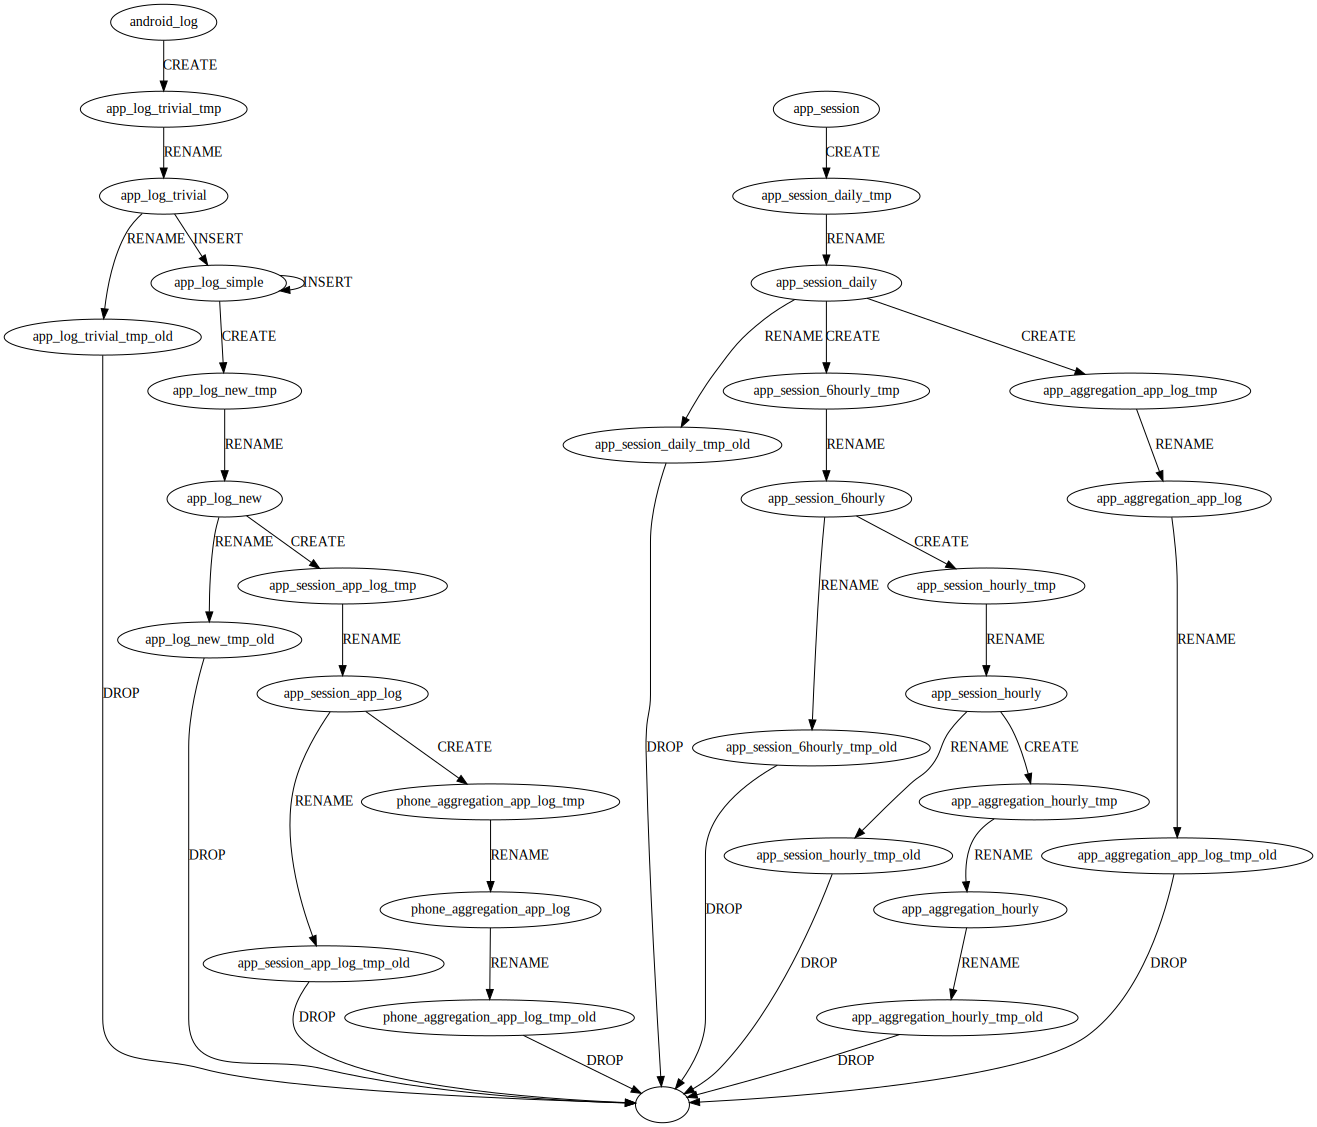

In [15]:
import networkx as nx
from graphviz import Digraph
from IPython.display import display_svg

G = nx.DiGraph()
G.add_edges_from(edges)

dot = Digraph()
for node in G.nodes:
    dot.node(node)
for n1, n2, data in G.edges(data=True):
    dot.edge(n1, n2, label=data['op'])

dot.render("lineage2", format='svg')
display_svg(dot)